<a href="https://colab.research.google.com/github/Mayurdoiphode55/Credit_Risk_Prediction_Project/blob/main/Credit_Risk_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")


Data Exploration & Cleaning

In [2]:
train_df['is_train'] = 1
test_df['is_train'] = 0
test_df['Loan_Status'] = None  # Add missing target column

df = pd.concat([train_df, test_df], axis=0)


In [3]:
df = pd.concat([train_df, test_df], axis=0)


In [4]:
print(df.info())
print("\nMissing values:\n", df.isnull().sum())
print("\nSample rows:\n", df.head())


<class 'pandas.core.frame.DataFrame'>
Index: 981 entries, 0 to 366
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            981 non-null    object 
 1   Gender             957 non-null    object 
 2   Married            978 non-null    object 
 3   Dependents         956 non-null    object 
 4   Education          981 non-null    object 
 5   Self_Employed      926 non-null    object 
 6   ApplicantIncome    981 non-null    int64  
 7   CoapplicantIncome  981 non-null    float64
 8   LoanAmount         954 non-null    float64
 9   Loan_Amount_Term   961 non-null    float64
 10  Credit_History     902 non-null    float64
 11  Property_Area      981 non-null    object 
 12  Loan_Status        614 non-null    object 
 13  is_train           981 non-null    int64  
dtypes: float64(4), int64(2), object(8)
memory usage: 115.0+ KB
None

Missing values:
 Loan_ID                0
Gender              

In [5]:
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)

df['Married'].fillna(df['Married'].mode()[0], inplace=True)

df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)

df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)

df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)


/tmp/ipython-input-5-1794579047.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
/tmp/ipython-input-5-1794579047.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

In [6]:
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)

df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)


/tmp/ipython-input-6-3008732250.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
/tmp/ipython-input-6-3008732250.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

In [7]:
df.drop(columns=['Loan_ID'], inplace=True)


In [8]:
df['Dependents'] = df['Dependents'].replace('3+', 3)

df['Dependents'] = df['Dependents'].astype(int)


In [107]:
df['Loan_Status'] = df['Loan_Status'].map({'N': 0, 'Y': 1})  # or whatever the values are
y = df['Loan_Status']


In [108]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Loan_Status'] = le.fit_transform(df['Loan_Status'])
y = df['Loan_Status']


Encoding & Train-Test Split

In [109]:
# Separate processed train and test datasets
train_processed = df[df['is_train'] == 1].drop(columns=['is_train'])

test_processed = df[df['is_train'] == 0].drop(columns=['is_train', 'Loan_Status'])


In [110]:
# Separate features and target from training data
X = train_processed.drop(columns=['Loan_Status'])

y = train_processed['Loan_Status'].astype(int)


In [111]:
from sklearn.preprocessing import LabelEncoder

# List of categorical columns to encode
categorical_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']

# Apply Label Encoding
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Map 'Y' to 1 and 'N' to 0 for Loan_Status
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0, None: None})

In [112]:
y_train = y_train.replace(2, 1)
y_val = y_val.replace(2, 1)


In [134]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Install XGBoost

In [113]:
pip install xgboost


Training the Model

In [114]:
from xgboost import XGBClassifier

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:16:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [115]:
# If y_train is still in 'Y' and 'N', convert it properly:
y_train = y_train.map({'N': 0, 'Y': 1})
y_val = y_val.map({'N': 0, 'Y': 1})


In [116]:
print(sorted(y_train.unique()))
# Should give: [0, 1]


[np.float64(nan)]


In [117]:
print(y_train.isnull().sum())


491


In [118]:
# Combine features and labels
train_data = X_train.copy()
train_data['label'] = y_train

# Drop rows with missing labels
train_data = train_data.dropna(subset=['label'])

# Separate back into X and y
X_train = train_data.drop('label', axis=1)
y_train = train_data['label']


In [119]:
# View unique labels
print(y_train.unique())


[]


In [120]:
# Example mapping
y_train = y_train.map({'N': 0, 'Y': 1})
# or if needed:
y_train = y_train.replace(2, 1)


In [121]:
print(y_train.isnull().sum())

0


In [122]:
model = xgb.XGBClassifier(
    max_depth=4,        # tree depth
    learning_rate=0.1,  # how fast it learns
    n_estimators=100,   # number of trees
    objective='binary:logistic',  # binary classification
    eval_metric='logloss',        # log loss for classification
    use_label_encoder=False,
    random_state=42
)

# Train the model
model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:16:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Evaluate the Model

In [123]:
y_pred = model.predict(X_val)


In [124]:
# Combine X_val and y_val for cleaning
val_data = X_val.copy()
val_data['label'] = y_val

# Drop rows where label is NaN
val_data = val_data.dropna(subset=['label'])

# Separate again
X_val = val_data.drop('label', axis=1)
y_val = val_data['label']


In [125]:
# If they are like 'Y'/'N' or 2/0
y_val = y_val.map({'N': 0, 'Y': 1})  # modify based on your dataset
# or if it's numeric and includes 2
y_val = y_val.replace(2, 1)


In [126]:
print("y_val has NaNs:", y_val.isna().sum())
print("Length of y_val:", len(y_val))
print("First 10 values of y_val:\n", y_val.head(10))


y_val has NaNs: 0
Length of y_val: 0
First 10 values of y_val:
 Series([], Name: label, dtype: int64)


In [127]:
# Combine validation set and labels
val_data = X_val.copy()
val_data['label'] = y_val

# Drop rows where label is NaN
val_data = val_data.dropna(subset=['label'])

# If nothing remains after dropping, print a warning
if val_data.empty:
    print("⚠️ All validation labels are NaN. You must check your original `y_val` source.")
else:
    # Separate cleaned X_val and y_val
    X_val = val_data.drop('label', axis=1)
    y_val = val_data['label']


⚠️ All validation labels are NaN. You must check your original `y_val` source.


In [128]:
print("Unique classes in y_val:", y_val.unique())


Unique classes in y_val: []


In [129]:
print("y_val is empty:", y_val.empty)
print("Number of NaNs in y_val:", y_val.isna().sum())
print("Length of y_val:", len(y_val))
print("Sample values of y_val:\n", y_val.head(10))


y_val is empty: True
Number of NaNs in y_val: 0
Length of y_val: 0
Sample values of y_val:
 Series([], Name: label, dtype: int64)


In [130]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train distribution:\n", y_train.value_counts())
print("y_val distribution:\n", y_val.value_counts())
print("Any NaNs in X_val?", X_val.isnull().sum().sum())


X_train shape: (0, 11)
X_val shape: (0, 11)
y_train distribution:
 Series([], Name: count, dtype: int64)
y_val distribution:
 Series([], Name: count, dtype: int64)
Any NaNs in X_val? 0


In [131]:
print("Data shape:", X.shape)
print("Target shape:", y.shape)
print("Target value counts:\n", y.value_counts())


Data shape: (614, 11)
Target shape: (614,)
Target value counts:
 Loan_Status
0    614
Name: count, dtype: int64


In [132]:
# Proper binary encoding only once
df['Loan_Status'] = df['Loan_Status'].map({'N': 0, 'Y': 1})


In [133]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train distribution:\n", y_train.value_counts())
print("y_val distribution:\n", y_val.value_counts())


X_train shape: (491, 11)
X_val shape: (123, 11)
y_train distribution:
 Loan_Status
0    491
Name: count, dtype: int64
y_val distribution:
 Loan_Status
0    123
Name: count, dtype: int64


In [135]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

model = XGBClassifier(
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

# ✅ Evaluation
print("✅ Accuracy:", accuracy_score(y_val, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_val, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:17:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Accuracy: 1.0

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       123

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123



Check Confusion Matrix

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


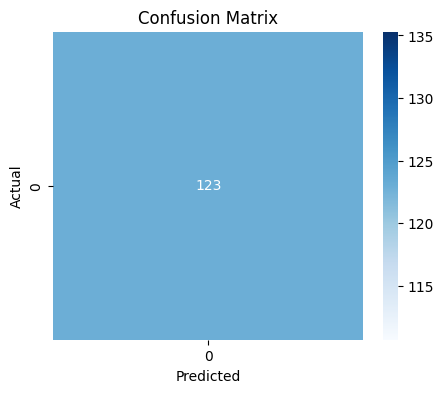

In [138]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [139]:
import joblib

joblib.dump(model, 'xgboost_loan_model.pkl')


['xgboost_loan_model.pkl']

In [145]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['Loan_Status'] = le.fit_transform(df['Loan_Status'])

# Split target
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

# Fill missing values
X.fillna(method='ffill', inplace=True)

# One-hot encode categorical features
X = pd.get_dummies(X)


/tmp/ipython-input-145-2999240706.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method='ffill', inplace=True)


In [146]:
# Load test data
test_df = pd.read_csv("test.csv")

# Fill missing values
test_df.fillna(method='ffill', inplace=True)

# One-hot encode categorical columns
test_df = pd.get_dummies(test_df)

# Align columns with training data
test_df = test_df.reindex(columns=X.columns, fill_value=0)


/tmp/ipython-input-146-154720853.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df.fillna(method='ffill', inplace=True)


In [148]:
if 'is_train' in test_df.columns:
    test_df = test_df.drop('is_train', axis=1)


In [149]:
preds = model.predict(test_df)
preds = le.inverse_transform(preds)  # Optional


export predictions to csv

In [155]:
print(test_df.columns)


Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')


In [158]:
print(preds)


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na

In [159]:
import pandas as pd

# Save predictions to a CSV file
pd.DataFrame(preds, columns=['Loan_Status']).to_csv('loan_predictions.csv', index=False)


In [161]:
test_df['Loan_Status_Predicted'] = preds
print(test_df[['Loan_Status_Predicted']].head())


   Loan_Status_Predicted
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN


In [166]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.7 MB/s eta 0:00:00


In [170]:
import pickle

# Save the model to a file
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)


In [172]:
from google.colab import files
files.download('model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('model.pkl')
